In [1]:
begin
    import Pkg
    Pkg.activate(".")
    Pkg.instantiate()
    using LinearAlgebra
    using Images
    using MultivariateStats
    using Printf
    using Plots
    using RDatasets
end

 Activating environment at `~/Study/3year/econometrics/julia/julia_metrics_tutorials/svd_pca/Project.toml`
┌ Info: Precompiling RDatasets [ce6b1742-4840-55fa-b093-852dadbb1d8b]
└ @ Base loading.jl:1278
┌ Warning: The call to compilecache failed to create a usable precompiled cache file for RDatasets [ce6b1742-4840-55fa-b093-852dadbb1d8b]
│   exception = ErrorException("Required dependency DataFrames [a93c6f00-e57d-5684-b7b6-d8193f3e46c0] failed to load from a cache file.")
└ @ Base loading.jl:1042


## Часть первая, PCA

Пусть у нас есть $X_{n \times k}$ – матрица объектов-признаков (перед началом использования алгоритма признаки необходимо центрировать и нормировать), и нам интересно понизить размерность с $n$ до $d$. То есть мы хотим спроецировать наши признаки на линейную оболочку $Lin(u_1, u_2, \ldots, u_d),$  где вектора $u_1, u_2, \ldots, u_d$ отвечают следующим условиям:

$$\langle u_i, u_j \rangle= 0$$

$$||u_i||^2 = 1$$

При проецировании выборки на вектора $u_1, u_2, \ldots, u_d$ получается максимальная дисперсия среди всех возможных способов выбрать $d$ компонент.

Запишем теперь проекцию $XU_d$ выборки $X$ на $U_d,$ где $U_d = (u_1, u_2, \ldots, u_d)$.

Наша задача максимизировать дисперсию проекции, более того нам известно, что
$$Var(XU_d) = tr(U_d^{T}X^{T}XU_{d}) = \sum_{i=1}^{d} ||Xu_i||^2$$

Теперь поставим задачу для первой компоненты:

\begin{align}
&||Xu_1||^2 \longrightarrow \max \\
&||u_1||^2 \leq 1
\end{align}

Запишем Лагранжиан:

$$\Lambda = ||Xu_1||^2 - \lambda(||u_1||^2 - 1) \longrightarrow \max$$

Тогда:

$$ \dfrac{\partial\Lambda}{\partial u_1} = 2X^{T}Xu_1 - 2 \lambda u_1 = 0 $$


Отсюда получаем, что $X^{T}Xu_1 = \lambda u_1, $ следовательно $u_1$ – случайный вектор матрицы $X^TX$.

Теперь запишем реализованный в Julia алгоритм для PCA

Пусть у нас есть $X_{train}$ и $X_{test}$, возьмем их из датасета iris

In [2]:
plotly()

┌ Info: For saving to png with the Plotly backend PlotlyBase has to be installed.
└ @ Plots /Users/ivan/.julia/packages/Plots/oZheM/src/backends.jl:372


Plots.PlotlyBackend()

In [3]:
iris = dataset("datasets", "iris")

,SepalLength,SepalWidth,PetalLength,PetalWidth,Species
,Float64,Float64,Float64,Float64,Cat…
1,5.1,3.5,1.4,0.2,setosa
2,4.9,3.0,1.4,0.2,setosa
3,4.7,3.2,1.3,0.2,setosa
4,4.6,3.1,1.5,0.2,setosa
5,5.0,3.6,1.4,0.2,setosa
6,5.4,3.9,1.7,0.4,setosa
7,4.6,3.4,1.4,0.3,setosa
8,5.0,3.4,1.5,0.2,setosa
9,4.4,2.9,1.4,0.2,setosa


Xtr = convert(Matrix, iris[1:2:end,1:4])'

In [4]:
Xtr_labels = convert(Vector, iris[1:2:end,5])

75-element Array{CategoricalArrays.CategoricalValue{String,UInt8},1}:
 "setosa"
 "setosa"
 "setosa"
 "setosa"
 "setosa"
 "setosa"
 "setosa"
 "setosa"
 "setosa"
 "setosa"
 "setosa"
 "setosa"
 "setosa"
 ⋮
 "virginica"
 "virginica"
 "virginica"
 "virginica"
 "virginica"
 "virginica"
 "virginica"
 "virginica"
 "virginica"
 "virginica"
 "virginica"
 "virginica"

In [5]:
Xte = convert(Matrix, iris[2:2:end,1:4])'

4×75 Adjoint{Float64,Array{Float64,2}}:
 4.9  4.6  5.4  5.0  4.9  4.8  4.3  5.7  …  6.4  6.9  6.9  6.8  6.7  6.5  5.9
 3.0  3.1  3.9  3.4  3.1  3.4  3.0  4.4     3.1  3.1  3.1  3.2  3.0  3.0  3.0
 1.4  1.5  1.7  1.5  1.5  1.6  1.1  1.5     5.5  5.4  5.1  5.9  5.2  5.2  5.1
 0.2  0.2  0.4  0.2  0.1  0.2  0.1  0.4     1.8  2.1  2.3  2.3  2.3  2.0  1.8

In [6]:
Xte_labels = convert(Vector, iris[2:2:end,5])

75-element Array{CategoricalArrays.CategoricalValue{String,UInt8},1}:
 "setosa"
 "setosa"
 "setosa"
 "setosa"
 "setosa"
 "setosa"
 "setosa"
 "setosa"
 "setosa"
 "setosa"
 "setosa"
 "setosa"
 "setosa"
 ⋮
 "virginica"
 "virginica"
 "virginica"
 "virginica"
 "virginica"
 "virginica"
 "virginica"
 "virginica"
 "virginica"
 "virginica"
 "virginica"
 "virginica"

Теперь обучим PCA и уменьшим размерность 

In [7]:
M = fit(PCA, Xtr; maxoutdim=3)

LoadError: UndefVarError: Xtr not defined

In [8]:
Yte = MultivariateStats.transform(M, Xte)

LoadError: UndefVarError: M not defined

In [9]:
Xr = reconstruct(M, Yte)

LoadError: UndefVarError: M not defined

In [10]:
setosa = Yte[:, Xte_labels .== "setosa"];

LoadError: UndefVarError: Yte not defined

In [11]:
versicolor = Yte[:,Xte_labels.=="versicolor"];

LoadError: UndefVarError: Yte not defined

In [12]:
virginica = Yte[:,Xte_labels.=="virginica"];

LoadError: UndefVarError: Yte not defined

Теперь посмотрим на визуализацию PCA

In [13]:
p = scatter(setosa[1,:],setosa[2,:],setosa[3,:],marker=:circle,linewidth=0)

LoadError: UndefVarError: setosa not defined

In [14]:
scatter!(versicolor[1,:],versicolor[2,:],versicolor[3,:],marker=:circle,linewidth=0)

LoadError: UndefVarError: versicolor not defined

In [15]:
scatter!(virginica[1,:],virginica[2,:],virginica[3,:],marker=:circle,linewidth=0)

LoadError: UndefVarError: virginica not defined

In [16]:
plot!(p,xlabel="PC1",ylabel="PC2",zlabel="PC3")

LoadError: UndefVarError: p not defined

Для того, чтобы более детально изучить возможности PCA, вы можете изучить документацию в Julia: https://multivariatestatsjl.readthedocs.io/en/latest/pca.html

## Часть вторая, SVD

\begin{align}
&A = U \Sigma V^{T} \\
&A \in \mathbb{C}^{m \times n} \\
&U_{m \times m} \text{ – комплексная унитарная матрица} \\
&\Sigma_{m \times n} = Diag(\sigma_1, \ldots, \sigma_r, 0, \ldots, 0) \\ 
&V^{T}_{n \times n} \text{ – комплексная унитарная матрица}
\end{align}

$\sigma_1^2, \ldots, \sigma_r^2$ – положительные вещественные собственные значения матрицы $AA^T$ и $A^TA$

A = $(a_{ij})_{1 \leqslant i \leqslant m, 1 \leqslant j \leqslant n}$. Если все $a_{ij} \in \mathbb{R}$, то $U$ и $V$ ортогональные.

Столбцы-векторы $U$ $(u_1, \ldots, u_r)$ – ортонормированные собственные векторы матрицы $AA^T$

Строки-векторы $V^T$ $(\nu_1^T, \ldots, \nu_r^T)$ - ортонормированные собственные векторы матрицы $A^TA$

SVD(Singular Value Decomposition) представляет собой обобщение разложения матрицы по собственным векторам.
Рассмотрим пример использования svd в Julia для сжатия изображений.

### Пример SVD

В Julia функция `svd` лежит в библиотеке `LinearAlgebra`. К матрицам $U, \Sigma, V^T$ можно обратиться как полям:
`F = svd(...); F.U, F.S, F.Vt`

In [17]:
F = svd(rand(5, 3))

SVD{Float64,Float64,Array{Float64,2}}
U factor:
5×3 Array{Float64,2}:
 -0.509583  -0.705595   -0.294779
 -0.139839   0.0970661  -0.261238
 -0.624659   0.575098   -0.426907
 -0.502017  -0.21599     0.590243
 -0.280266   0.339594    0.560557
singular values:
3-element Array{Float64,1}:
 2.2657361299351435
 0.5839874889202659
 0.05813262391456934
Vt factor:
3×3 Array{Float64,2}:
 -0.642497  -0.441133  -0.626577
 -0.353739   0.896083  -0.268149
  0.679754   0.04936   -0.731777

### Сжатие изображений

В качестве примера возьмем картину Хоппера "Полуночники".
Загрузим ее в наш ноутбук. Зная оригинальное разрешение в пикселях, посмотрим на сжатие с помощью SVD (применяем его к каждому отдельному цветовому каналу и беерм какое-то количество наибольших компонент, отвечающих наибольшим сингулярным значениям из нашего разложения). На самом деле сжатие в нашем примере это лишь этап, далее мы реконструируем наше изображение. То есть в итоге мы строим low rank approximation картинки. На практике используются другие алгоритмы (например, дискретное косинусное преобразование в алгоритме JPG), это лишь демонстрация того, как ортогональные преобразования позволяют нам делать всякие классные штуки.

Для удобства материал, представленный здесь (https://juliaimages.org/latest/democards/examples/color_channels/color_separations_svd/) обернут в функции.

Опуская все технические детали о представлении картинок в Julia (например, `N0f8` представление, о котором можно почитать либо в документации `JuliaImages`, либо просто в интернете) в коде происходит следующее:
`rank_approx` берет SVD из одного канала, берет k наибольших компонент и преобразует в формат для реконструирования через RGB c помощью функции `colorview`.
В итоге выводятся картинки с реконструированной картинкой из k компонент и отображается сжатый размер в пикселях (авторы заранее извиняются за дублирование сообщений). Если бы мы выводили информацию отдельно для каждого канала, то размер должен был быть в байтах, один пиксель мы принимаем за 3 байта (в соответствии с тремя каналами). Для того, чтобы понять во сколько раз больше реконструированное изображение, мы сравниваем во сколько раз оригинальная картинка больше. Как можно заметить, довольно большое сжатие (в 21 раз для 100 компонент), дает уже визуально (по крайней мере в масштабе ноутбука) неотличимое представление от оригинала.

Поиграться с сжатием можно здесь: http://timbaumann.info/svd-image-compression-demo/.

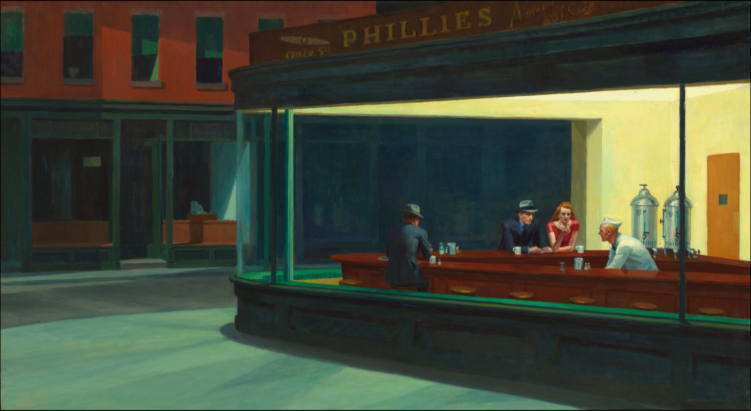

In [18]:
begin
    path = pwd() * "/assets/nighthawks.jpg"
    nighthawks = load(path)
end

In [19]:
nhawks_tensor = permutedims(channelview(nighthawks), (2,3,1));

In [20]:
# Original picture
pixels = size(nhawks_tensor)[1] * size(nhawks_tensor)[2]

19644000

In [21]:
M_singular = svdvals(nhawks_tensor[:, :, 1]);
M_singular = M_singular[M_singular .> 0];
println(size(M_singular))

(3274,)


In [22]:
plot(1:size(M_singular)[1], M_singular, seriestype = :scatter, xlims=[0, 100], ylabel="Value",xlabel="Index of singular value", label=false, title="Singular values in first channel")

<!DOCTYPE html>
 
 
 Plots.jl

In [23]:
# Taken from https://juliaimages.org/latest/democards/examples/color_channels/color_separations_svd/

function rank_approx(F::SVD, k)
    U, S, V = F
    M = U[:, 1:k] * Diagonal(S[1:k]) * V[:, 1:k]'
    compressed_size = k * (1 + size(M)[1] + size(M)[2])
    @printf("k: %d, Compressed size: %ld, Compression ratio: %.4f\n", k, compressed_size, pixels / compressed_size)
    clamp01!(M) # clamps values onto [0,1]
end

rank_approx (generic function with 1 method)

In [24]:
function ImageCompression(channels, thresholds::AbstractArray)
    """
    Wrapped around code presented here:
    https://juliaimages.org/latest/democards/examples/color_channels/color_separations_svd/
    
    channels : ChannelView of an image, i.e. channelview(img)
    Make sure that channels dimension is last:
        size(img) = (m, n, c), where c is the number of channels
        or the function will throw DomainError
    thresholds: an array containg various numbers of singular values to keep
    """
    
    if size(channels)[3] != 3
        throw(DomainError(size(channels)[3], "Channels dim should be 3"))
    end
    svdfactors = svd.(eachslice(channels; dims=3))
    imgs = map(thresholds) do k
        colorview(RGB, rank_approx.(svdfactors, k)...)
    end
    return imgs
end

ImageCompression (generic function with 1 method)

k: 1, Compressed size: 9275, Compression ratio: 2117.9515
k: 1, Compressed size: 9275, Compression ratio: 2117.9515
k: 1, Compressed size: 9275, Compression ratio: 2117.9515
k: 5, Compressed size: 46375, Compression ratio: 423.5903
k: 5, Compressed size: 46375, Compression ratio: 423.5903
k: 5, Compressed size: 46375, Compression ratio: 423.5903
k: 10, Compressed size: 92750, Compression ratio: 211.7951
k: 10, Compressed size: 92750, Compression ratio: 211.7951
k: 10, Compressed size: 92750, Compression ratio: 211.7951
k: 25, Compressed size: 231875, Compression ratio: 84.7181
k: 25, Compressed size: 231875, Compression ratio: 84.7181
k: 25, Compressed size: 231875, Compression ratio: 84.7181
k: 50, Compressed size: 463750, Compression ratio: 42.3590
k: 50, Compressed size: 463750, Compression ratio: 42.3590
k: 50, Compressed size: 463750, Compression ratio: 42.3590
k: 100, Compressed size: 927500, Compression ratio: 21.1795
k: 100, Compressed size: 927500, Compression ratio: 21.1795
k

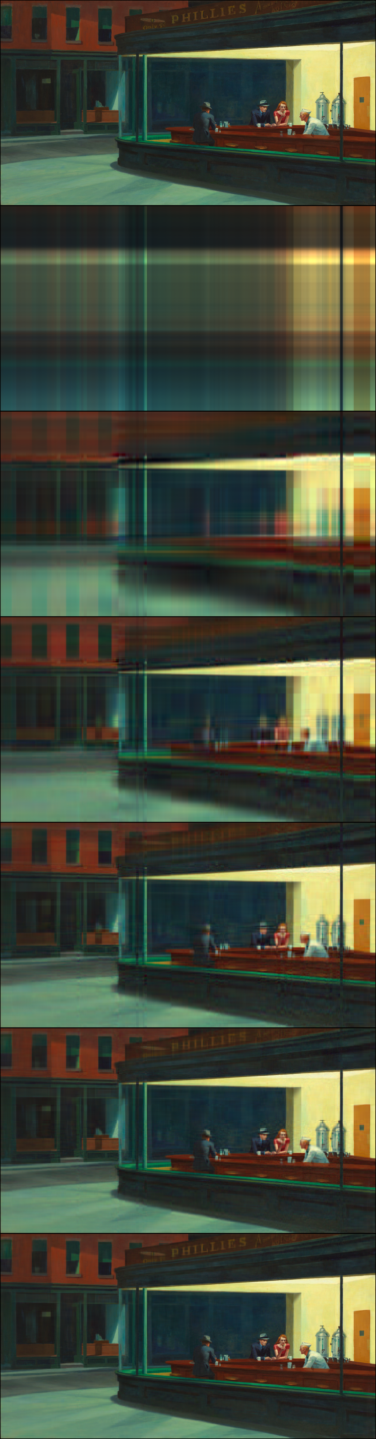

In [25]:
begin
    thresholds = [1, 5, 10, 25, 50, 100]
    mosaicview(nighthawks, ImageCompression(channelview(nhawks_tensor), thresholds)...; nrow=size(thresholds)[1] + 1, npad=15)
end

### Связь SVD с PCA

Обратимся к первой части. Мы смогли понять, что на самом деле поиск главных компонент связан с поиском собственных значений и собственных векторов ковариационной матрицы $X^TX$.
Как мы знаем, $X$ имеет SVD-разложение: $X = U \Sigma V^T$. Значит, $X^TX = V \Sigma^T U^T U \Sigma V^T = V \Sigma^T \Sigma V^T$. Таким образом, задача PCA сводится к поиску векторов-столбцов матрицы $V$, они и являются главными компонентами. Большим сингулярным значениям соответствуют главные компоненты объясняющие большую часть дисперсии.

## References

* G. Strang. Introduction to Linear Algebra

* https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture12-factorizations.pdf

* https://juliaimages.org/stable/

* https://multivariatestatsjl.readthedocs.io/en/latest/ (документация немного старая, лучше смотреть на github: https://github.com/JuliaStats/MultivariateStats.jl в разделе docs)